### Create labels dataarray

In [1]:
import dask
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import matplotlib.pyplot as plt
print('loaded libraries')

loaded libraries


In [2]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
dir_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
ds = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc", chunks={'time':100})
#ds_region = ds.sel(xh=slice(-130, -70), yh=slice(8, 38))
static_region = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.static.nc").sel(xh=slice(-130, -70), yh=slice(8, 38))
#ds_static_region = xr.merge([static_region,ds_region])

In [3]:
#load all blobs
blobs = xr.open_mfdataset(f"{mt_path}/ocetracv6/ocetrac-v6-blobs-tos-t1*.nc")#,chunks={'time':1})
blobs

<xarray.Dataset>
Dimensions:  (time: 1100, xh: 1440, yh: 1080)
Coordinates:
  * time     (time) object 0186-03-15 12:00:00 ... 0189-12-14 12:00:00
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    labels   (time, yh, xh) float64 dask.array<chunksize=(275, 1080, 1440), meta=np.ndarray>

Relabel events

In [4]:
unique_years = np.unique(blobs.time.dt.year.values)

for i, year in enumerate(unique_years[1:]):
    print(year)
    print(i)
    print(f"year {year} calculation")
    N_before_year = blobs.labels.isel(time=(blobs.time.dt.year==year-1)).max().values
    print(N_before_year)
    blobs["labels"] = xr.where(blobs.time.dt.year==year, blobs.labels + N_before_year, blobs.labels)

187
0
year 187 calculation
1950.0
188
1
year 188 calculation
3807.0
189
2
year 189 calculation
5743.0


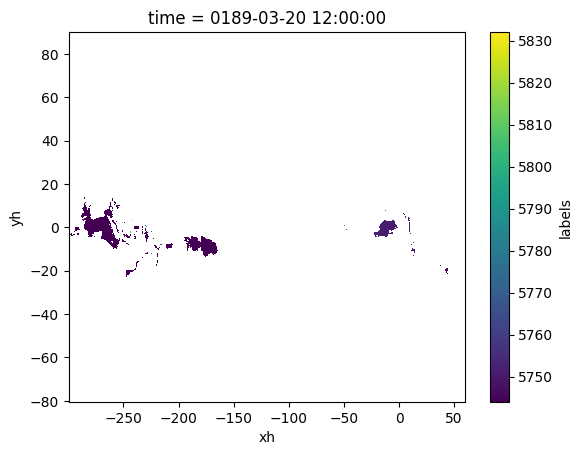

In [5]:
#Check that relabeling worked
blobs.labels.isel(time=130*6+50).plot()

In [6]:
# #These are all the IDs (labels) global
ids = np.unique(blobs.labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([1.000e+00, 2.000e+00, 3.000e+00, ..., 7.791e+03, 7.792e+03,
       7.793e+03])

In [13]:
# #These are all the IDs (labels) in the region
# ids = np.unique(blobs.labels.sel(xh=slice(-130, -70), yh=slice(8, 38)))
# ids = np.array([id for id in ids if ~np.isnan(id)])
# ids

array([  39.,  136.,  210., ..., 7608., 7626., 7645.])

In [7]:
reg_blobs = blobs.labels#.sel(xh=slice(-130, -70), yh=slice(8, 38))
reg_blobs

<xarray.DataArray 'labels' (time: 1100, yh: 1080, xh: 1440)>
dask.array<where, shape=(1100, 1080, 1440), dtype=float64, chunksize=(275, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0186-03-15 12:00:00 ... 0189-12-14 12:00:00
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95

In [8]:
#checking
startday = blobs.time.values.astype(dtype='str')[0]
print(startday)
endday = blobs.time.values.astype(dtype='str')[-1]
print(endday)
#blobs.time.values.astype(dtype='datetime64[D]')[0]

0186-03-15 12:00:00
0189-12-14 12:00:00


In [9]:
ds_region = ds.sel(time=slice(startday,endday))#.sel(xh=slice(-130, -70), yh=slice(8, 38))
ds_region_blobs = xr.merge([ds_region,reg_blobs],join='inner')
#.sel(xh = slice(-138, 0), yh = slice(8, 49))


In [10]:
ds_region_blobs

<xarray.Dataset>
Dimensions:     (nv: 2, time: 1100, xh: 1440, yh: 1080)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0186-03-15 12:00:00 ... 0189-12-14 12:00:00
  * xh          (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh          (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(27,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(27,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(27,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(27, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(27, 1080, 1440), meta=np.ndarray>
    labels      (time, yh, xh) float64 dask.array<chunksize=(275, 1080, 1440), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.01860101-01901231.tos.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

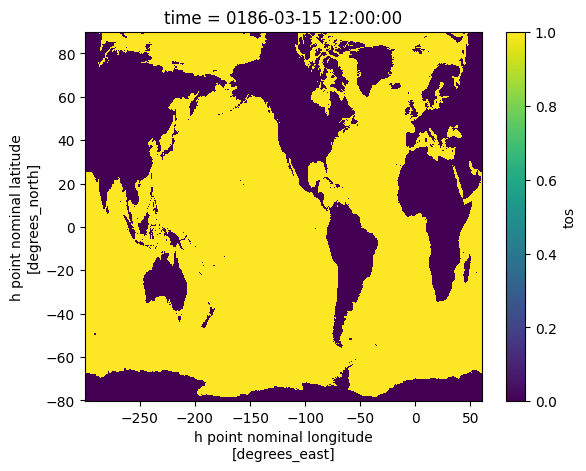

In [11]:
hot_water = ds_region_blobs['tos']#.sel(xh=slice(-130, -70), yh=slice(8, 38)) > 29 #previously binary_out
#lsmask = xr.ones_like(binary_out.isel(time=0))
mask_ocean = 1 * np.ones(ds_region_blobs['tos'].shape[1:]) * np.isfinite(ds_region_blobs['tos'].isel(time=0))
mask_land = 0 * np.ones(ds_region_blobs['tos'].shape[1:]) * np.isnan(ds_region_blobs['tos'].isel(time=0))
lomask = mask_ocean + mask_land
lomask.plot()

In [12]:
# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        blobs=(['time', 'yh', 'xh'], reg_blobs.values, reg_blobs.attrs),
        lomask=(['yh', 'xh'], lomask.values),

    ),
    coords=dict(
        xh=ds_region_blobs['tos'].xh,
        yh=ds_region_blobs['tos'].yh,
        time=ds_region_blobs['tos'].time,
    ),
    attrs=dict(description="Relabeled ocetrac-v6-run for the globe",
               data="tos from CM4.0", #full-period climatology
               task="radius=0.0, min_size_quartile=0.0",
               threshold='29 deg C'
)
)
ds_out

<xarray.Dataset>
Dimensions:  (time: 1100, yh: 1080, xh: 1440)
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 0186-03-15 12:00:00 ... 0189-12-14 12:00:00
Data variables:
    blobs    (time, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan nan
    lomask   (yh, xh) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  Relabeled ocetrac-v6-run for the globe
    data:         tos from CM4.0
    task:         radius=0.0, min_size_quartile=0.0
    threshold:    29 deg C

In [13]:
## for nomenclature
d = blobs.isel(time = 0).time.dt
e = blobs.isel(time = -1).time.dt
date_d = f"{d.year.values:0004}{d.month.values:02}{d.day.values:02}"
date_e = f"{e.year.values:0004}{e.month.values:02}{e.day.values:02}"
print(date_d)
print(date_e)

01860315
01891214


In [13]:
#"ocetrac-v5-blobs-tos-t1-i1-r3-msq75-0186-03-15-0186-11-02.nc"

In [14]:
ds_out.to_netcdf(f"/pub/mariant3/WarmWaterMasses/data/ocetracv6/ocetrac-v6-processed/ocetrac-v6-blobs-tos-t1-r1-msq0-{date_d}-{date_e}-global.nc")